In [86]:
MODEL = 't5-base'
BATCH_SIZE = 8
NUM_PROCS = 4
EPOCHS = 10
# OUT_DIR = 'results_t5base/2k_samples'
OUT_DIR = 'results_t5_large_regularized/10k_samples_fixed'
MAX_LENGTH = 1024 # Maximum context length to consider while preparing dataset.
epoch_metrics = []
DRIVE_DATA_PATH = "/content/drive/MyDrive/processed/10k_samples"   # UPDATE PATH
CLEAN_TEXT_COLUMN='article'
SUMMARY_COLUMN='highlights'

In [87]:
!pip install tensorboard
!pip install tensorboard-data-server
!pip install google-cloud-storage
!pip install tbparse matplotlib seaborn pandas numpy



In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !mkdir -p /content/fixed_logs/
# !gsutil -m cp -r gs://models_checkpoint/models/results_t5_base_fixed/2k_samples/* /content/fixed_logs/

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Install gcsfuse
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

# 10k_regularized/10k_samples_fixed/events.out.tfevents.1764724302.669eb4a67fb3.690.2

# models_regularized_run/models/results_t5_base/2k_samples/events.out.tfevents.1764788556.fec5b49f987e.2140.3
# Create a local directory for mounting
!mkdir pegasus_large_50k
# models_regularized_run/models/results_t5_base/2k_samples
# Mount the GCS bucket
# Replace 'your-bucket-name' with the actual name of your GCS bucket
!gcsfuse --implicit-dirs pegasus_large_50k_2nd pegasus_large_50k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   6074      0 --:--:-- --:--:-- --:--:--  6083
OK
67 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gcsfuse is already the newest version (3.5.4).
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.
{"timestamp":{"seconds":1765232612,"nanos":302686673},"severity":"INFO","message":"Start gcsfuse/3.5.4 (Go version go1.24.11) for app \"\" using mount point: /content/pegasus_large_10k\n","mount-

In [109]:
# Create a local directory for mounting
!mkdir t5_10k_new
# models_regularized_run/models/results_t5_base/2k_samples
# Mount the GCS bucket
# Replace 'your-bucket-name' with the actual name of your GCS bucket
!gcsfuse --implicit-dirs t5_large_10_run_test2 t5_10k_new

{"timestamp":{"seconds":1765235812,"nanos":145593104},"severity":"INFO","message":"Start gcsfuse/3.5.4 (Go version go1.24.11) for app \"\" using mount point: /content/t5_10k_new\n","mount-id":"t5_large_10_run_test2-2026f6ad"}
{"timestamp":{"seconds":1765235812,"nanos":145620778},"severity":"INFO","message":"GCSFuse Config","mount-id":"t5_large_10_run_test2-2026f6ad","CLI Flags":{"implicit-dirs":"true"}}
{"timestamp":{"seconds":1765235812,"nanos":145667122},"severity":"INFO","message":"GCSFuse Config","mount-id":"t5_large_10_run_test2-2026f6ad","Full Config":{"AppName":"","CacheDir":"","CloudProfiler":{"AllocatedHeap":true,"Cpu":true,"Enabled":false,"Goroutines":false,"Heap":true,"Label":"gcsfuse-0.0.0","Mutex":false},"Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"DisableAutoconfig":false,"EnableAtomicRenameObject":true,"EnableGoogleLibAuth":true,"EnableHns":true,"EnableNewReader":true,"EnableUnsupportedPathSupport":false,"FileCache":{"CacheFileFor

In [110]:
# Example run directories
# models_regularized_run/models/results_t5_base/2k_samples
RUNS = {
"pegasus_large_10k": '/content/pegasus_large_10k/logs',
    "pegasus_2k": '/content/pegasus_2k/models/results_pegasus-large/logs',
    # "pegasus_cnn_50k":'/content/pegasus_cnn_daily_mail_50k/50k_samples',
    't5_large_10k':'/content/t5_large/10k_samples_fixed',
      't5_large_50k':'/content/t5_large/50k_samples_fixed',
    "10k_regularized":'/content/10k_regularized/10k_samples_fixed',
    't5_large_10_run_10k':'/content/t5_large_10_run/10k_samples_fixed',
    't5_large_10_run_50k':'/content/t5_large_10_run/50k_samples_fixed',
         't5_10k_new':'/content/t5_10k_new/10k_samples_fixed_modeified_configs'
    }


RUN_SIZES = {
    "pegasus_large_10k": 10000,
    "pegasus_2k": 2000,
    "pegasus_cnn_50k":50000,
    "t5_large_10k":10000,
    "t5_large_50k":50000,
    "10k_regularized":10000,
     "t5_large_10_run_10k":10000,
    "t5_large_10_run_50k":50000,
    't5_10k_new':10000
}

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/pegasus_large_10k/10k_samples/logs'

In [111]:
import pandas as pd
from tbparse import SummaryReader
import os

def load_run(run_path):
    reader = SummaryReader(run_path, pivot=False)
    df = reader.scalars  # TensorBoard scalars
    return df


In [112]:
from tbparse import SummaryReader

files = [f for f in os.listdir('/content/pegasus_cnn_daily_mail_50k/logs') if "events.out" in f]

for f in files:
    fp = os.path.join('/content/pegasus_cnn_daily_mail_50k/logs', f)
    print(f"\nTrying to load: {fp}")

    try:
        reader = SummaryReader(fp, pivot=False)
        df = reader.scalars
        print("Loaded scalars:", len(df))
        print(df.head())
    except Exception as e:
        print("❌ FAILED to load:", e)



Trying to load: /content/pegasus_cnn_daily_mail_50k/logs/events.out.tfevents.1765230396.0eeb31739fe8.2490.1
Loaded scalars: 0
Empty DataFrame
Columns: []
Index: []


In [113]:
def extract_metrics(run_name, run_path):
    import os
    import pandas as pd
    from tbparse import SummaryReader

    # Read event logs (auto-detect format: long or wide)
    reader = SummaryReader(run_path)
    df = reader.scalars

    # Detect long vs wide format
    is_long_format = "tag" in df.columns

    # Helper to extract values for a given tag in both formats
    def get_values(tag):
        if is_long_format:
            sub = df[df["tag"] == tag]
            return sub[["step", "value"]] if not sub.empty else None
        else:
            if tag in df.columns:
                # wide format: 'step' + tag column
                sub = df[["step", tag]].dropna()
                sub = sub.rename(columns={tag: "value"})
                return sub if not sub.empty else None
            else:
                return None

    # --- 1. TRAIN LOSS ---
    train_loss_raw = get_values("train/loss")
    if train_loss_raw is not None:
        train_loss = pd.DataFrame({
            "step": train_loss_raw["step"].values,
            "loss": train_loss_raw["value"].values
        })
    else:
        train_loss = None

    # --- 2. VALIDATION LOSS ---
    val_loss_raw = get_values("eval/loss")
    if val_loss_raw is not None:
        val_loss = pd.DataFrame({
            "step": val_loss_raw["step"].values,
            "loss": val_loss_raw["value"].values
        })
    else:
        val_loss = None

    # --- 3. ROUGE METRICS ---
    def get_last_metric(tag):
        m = get_values(tag)
        return m["value"].iloc[-1] if m is not None and not m.empty else None

    rouge1 = get_last_metric("eval/rouge1")
    rouge2 = get_last_metric("eval/rouge2")
    rougeL = get_last_metric("eval/rougeL")

    # --- 4. GPU USAGE ---
    gpu_raw = get_values("gpu_memory_gb")
    gpu_avg = gpu_raw["value"].mean() if gpu_raw is not None else None

    # --- 5. TRAINING TIME ---
    tt_raw = get_values("total_training_time_seconds")
    train_time = tt_raw["value"].iloc[0] if tt_raw is not None else None

    # --- 6. HALLUCINATION ---
    hall_path = os.path.join(run_path, "hallucination.csv")
    if os.path.exists(hall_path):
        hall_df = pd.read_csv(hall_path)
        hallucination = hall_df["hallucination_rate"].mean()
    else:
        hallucination = None

    # --- FINAL OUTPUT ---
    return {
        "run": run_name,
        "train_loss": train_loss,  # <--- always normalized DataFrame
        "val_loss": val_loss,      # <--- always normalized DataFrame
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "gpu_avg": gpu_avg,
        "train_time_sec": train_time,
        "hallucination": hallucination
    }


In [114]:
all_metrics = []

for run_name, run_path in RUNS.items():
    metrics = extract_metrics(run_name, run_path)
    print(metrics)
    all_metrics.append(metrics)

summary_df = pd.DataFrame([{
    "run": m["run"],
    "rouge1": m["rouge1"],
    "rouge2": m["rouge2"],
    "rougeL": m["rougeL"],
    "gpu_avg": m["gpu_avg"],
    "train_time_min": m["train_time_sec"] / 60 if m["train_time_sec"] else None,
    "hallucination": m["hallucination"]
} for m in all_metrics])

summary_df


{'run': 'pegasus_large_10k', 'train_loss':    step    loss
0    50  6.4597
1   100  4.8613
2   150  2.6181
3   200  1.1641
4   250  1.0163
5   300  0.9648
6   350  0.9379
7   400  0.9196
8   450  0.9070
9   500  0.9001, 'val_loss':    step      loss
0    50  4.896780
1   100  3.323179
2   150  1.199609
3   200  1.094601
4   250  1.060158
5   300  1.047659
6   350  1.040523
7   400  1.037587
8   450  1.035142
9   500  1.034184, 'rouge1': np.float64(0.3621712625026703), 'rouge2': np.float64(0.1508214771747589), 'rougeL': np.float64(0.2547246515750885), 'gpu_avg': None, 'train_time_sec': None, 'hallucination': None}
{'run': 'pegasus_2k', 'train_loss':     step    loss
0    100  6.6394
1    200  5.4466
2    300  4.6247
3    400  3.4460
4    500  2.0860
5    600  1.3629
6    700  1.1674
7    800  1.0999
8    900  1.0713
9   1000  1.0452
10  1100  1.0355, 'val_loss':     step      loss
0    100  4.900944
1    200  4.366906
2    300  3.381463
3    400  1.846226
4    500  1.359819
5    600  1.

,run,rouge1,rouge2,rougeL,gpu_avg,train_time_min,hallucination
0,pegasus_large_10k,0.362171,0.150821,0.254725,NaN,NaN,NaN
1,pegasus_2k,0.350719,0.141919,0.245699,NaN,NaN,NaN
2,t5_large_10k,0.596800,0.339700,0.562400,8.270022,246.942367,0.526667
3,t5_large_50k,0.600600,0.331100,0.554500,2.515252,NaN,NaN
4,10k_regularized,0.576600,0.317200,0.539500,NaN,NaN,0.525000
5,t5_large_10_run_10k,0.596800,0.339700,0.562400,8.270022,246.942367,0.526667
6,t5_large_10_run_50k,0.600600,0.331100,0.554500,2.515252,NaN,NaN
7,t5_10k_new,0.598400,0.341600,0.564900,8.267477,227.314144,0.522500


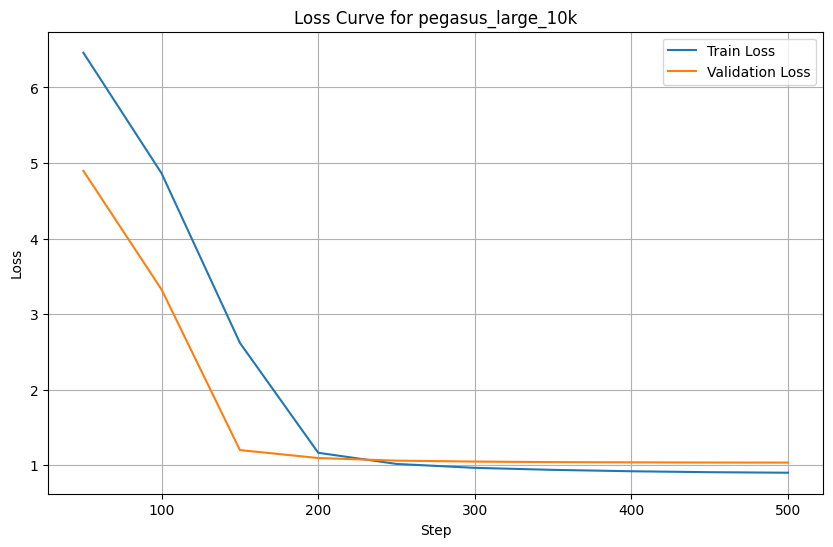

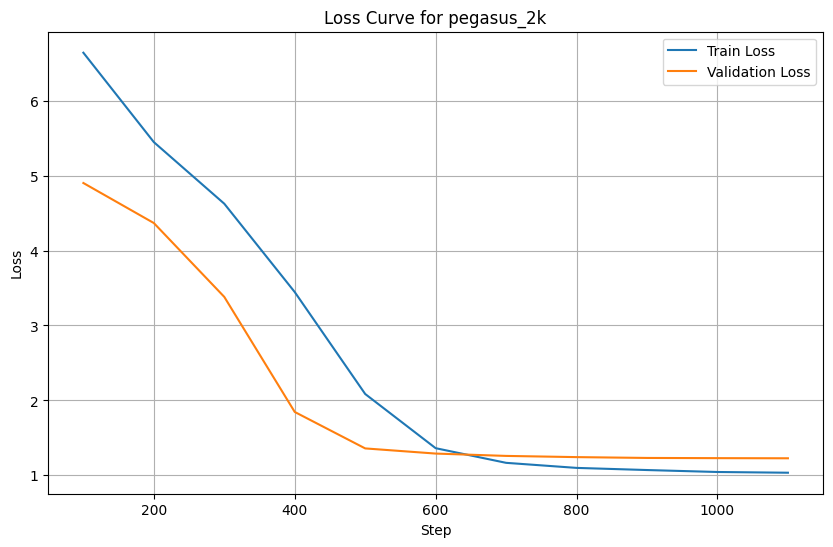

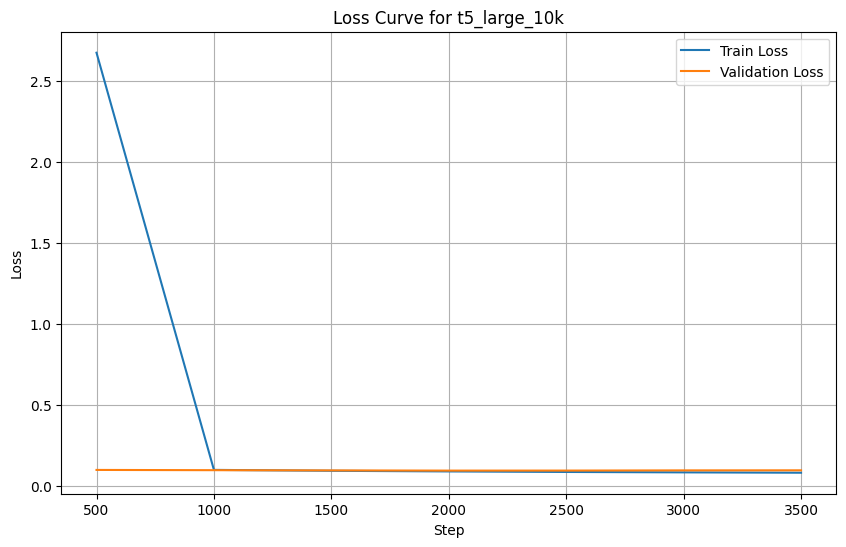

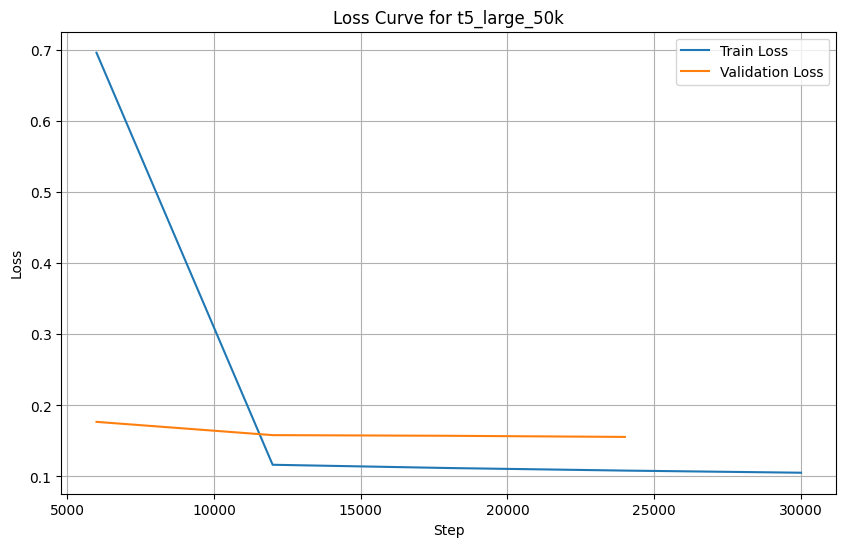

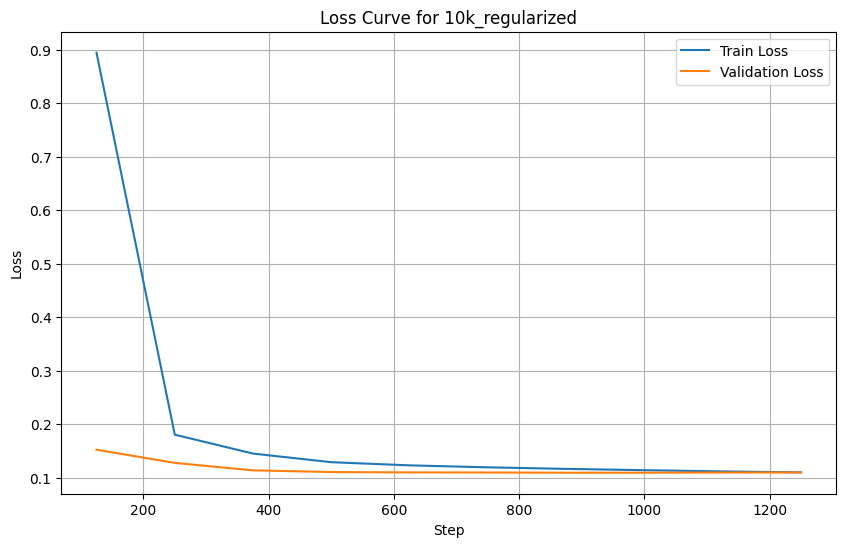

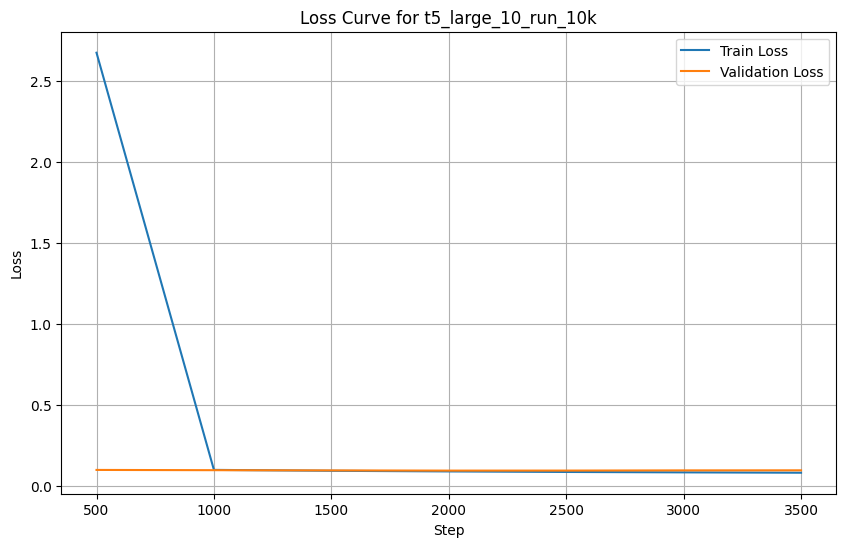

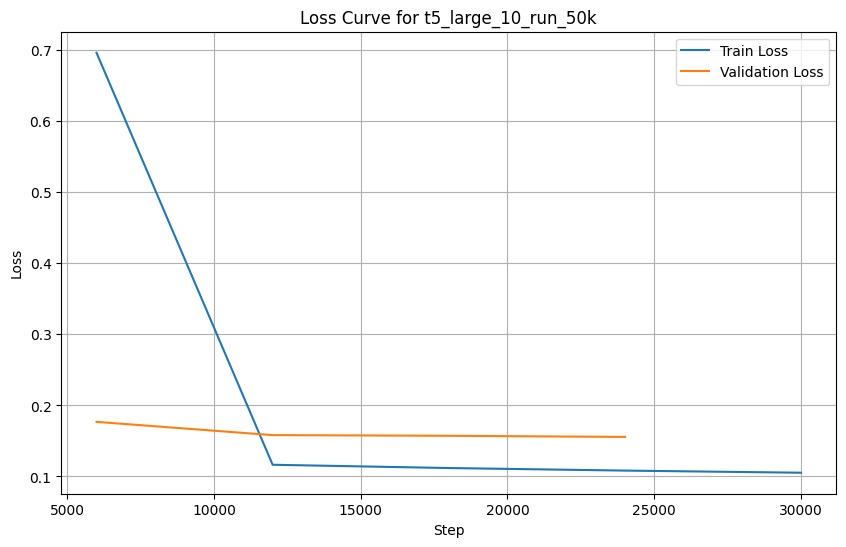

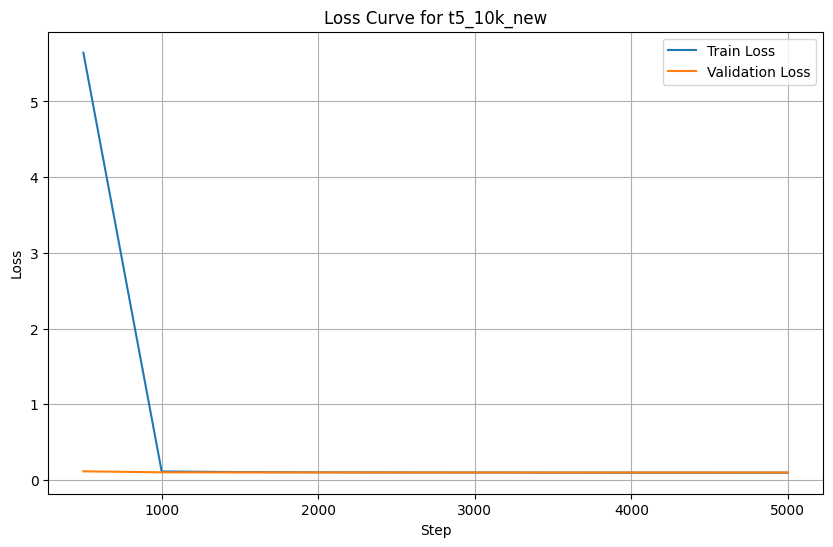

In [115]:
import matplotlib.pyplot as plt

for m in all_metrics:
    if m["train_loss"] is None or m["val_loss"] is None:
        continue

    plt.figure(figsize=(10,6))
    plt.plot(m["train_loss"]["step"], m["train_loss"]["loss"], label="Train Loss")
    plt.plot(m["val_loss"]["step"], m["val_loss"]["loss"], label="Validation Loss")

    plt.title(f"Loss Curve for {m['run']}")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


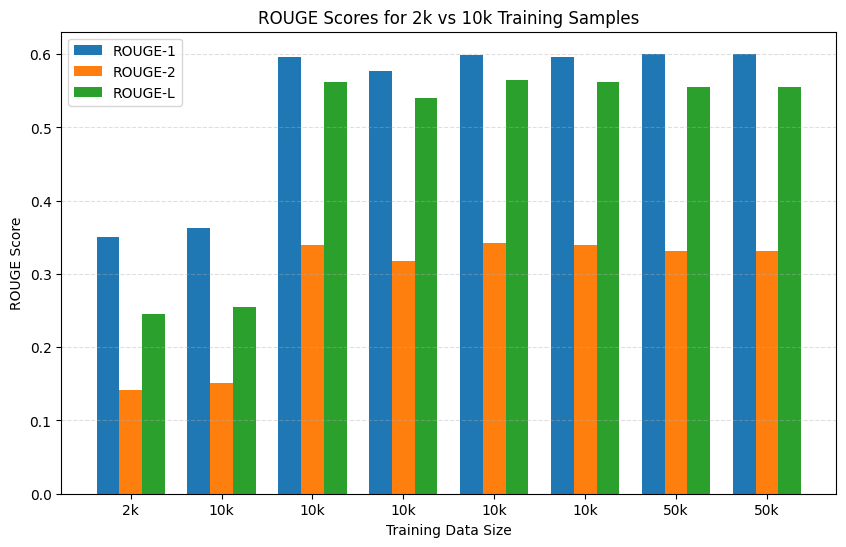

In [116]:
import matplotlib.pyplot as plt
import numpy as np

summary_df["data_size"] = summary_df["run"].map(RUN_SIZES)
df_sorted = summary_df.sort_values("data_size")


# Sort by size to ensure correct order 2k → 10k
df_sorted = summary_df.sort_values("data_size")

sizes = df_sorted["data_size"].tolist()
rouge1 = df_sorted["rouge1"].tolist()
rouge2 = df_sorted["rouge2"].tolist()
rougeL = df_sorted["rougeL"].tolist()

x = np.arange(len(sizes))  # number of groups
width = 0.25               # width of each bar

plt.figure(figsize=(10,6))

plt.bar(x - width, rouge1, width, label='ROUGE-1')
plt.bar(x,         rouge2, width, label='ROUGE-2')
plt.bar(x + width, rougeL, width, label='ROUGE-L')

plt.xticks(x, [f"{s//1000}k" for s in sizes])
plt.xlabel("Training Data Size")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores for 2k vs 10k Training Samples")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()
